Implementation of 2D elasto-plastic problem using FEniCS-X. The code is based on a [legacy solution](https://comet-fenics.readthedocs.io/en/latest/demo/2D_plasticity/vonMises_plasticity.py.html) for FEniCS 2019.

The program was tested for 0.3.1.0 version of Dolfinx.

In [1]:
import sys
sys.path.append("../")
from src import fenicsx_support as fs
from src import plasticity_framework as pf
from src import convex_return_mapping as crm # there is a conflict in the oder of imported modules

import meshio
import ufl
from dolfinx import fem, io, common
from mpi4py import MPI
from petsc4py import PETSc

import numpy as np

In [2]:
if MPI.COMM_WORLD.rank == 0:

    #It works with the msh4 only!!
    msh = meshio.read("mesh/thick_cylinder_coarse.msh")

    # Create and save one file for the mesh, and one file for the facets 
    triangle_mesh = fs.create_mesh(msh, "triangle", prune_z=True)
    line_mesh = fs.create_mesh(msh, "line", prune_z=True)
    meshio.write("thick_cylinder.xdmf", triangle_mesh)
    meshio.write("mt.xdmf", line_mesh)
    print(msh)


<meshio mesh object>
  Number of points: 50
  Number of cells:
    line: 2
    line: 14
    line: 2
    line: 11
    triangle: 69
  Cell sets: gmsh:bounding_entities
  Point data: gmsh:dim_tags
  Cell data: gmsh:physical, gmsh:geometrical


In [3]:
with io.XDMFFile(MPI.COMM_WORLD, "thick_cylinder.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    ct = xdmf.read_meshtags(mesh, name="Grid")

mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim - 1)

with io.XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "r") as xdmf:
    ft = xdmf.read_meshtags(mesh, name="Grid")

In [4]:
# elastic parameters
sig0_dim = 70e3 #[Pa]
Ri_dim = 1.0 #[m]

E = 70e3 / sig0_dim #[-]
nu = 0.3 #[-]
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = fem.Constant(mesh, PETSc.ScalarType(E/2./(1+nu)))

sig0 = 250 / sig0_dim #[-]
Et = E/100.  # tangent modulus
H = E*Et/(E-Et)  # hardening modulus

Re, Ri = 1.3, 1.   # external/internal radius

In [5]:
deg_u = 2
deg_stress = 2
V = fem.VectorFunctionSpace(mesh, ("CG", deg_u))
We = ufl.VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=4, quad_scheme='default')
W0e = ufl.FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')

W = fem.FunctionSpace(mesh, We)
W0 = fem.FunctionSpace(mesh, W0e)

In [6]:
sig = fem.Function(W)
sig_old = fem.Function(W)
p = fem.Function(W0, name="Cumulative_plastic_strain")
p_old = fem.Function(W0)
u = fem.Function(V, name="Total_displacement")
Du = fem.Function(V, name="Current_increment")
v_ = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)

deps = fem.Function(W, name="deps")

In [7]:
left_marker = 3
down_marker = 1
left_facets = ft.indices[ft.values == left_marker]
down_facets = ft.indices[ft.values == down_marker]
left_dofs = fem.locate_dofs_topological(V.sub(0), mesh.topology.dim-1, left_facets)
down_dofs = fem.locate_dofs_topological(V.sub(1), mesh.topology.dim-1, down_facets)

bcs = [fem.dirichletbc(PETSc.ScalarType(0), left_dofs, V.sub(0)), fem.dirichletbc(PETSc.ScalarType(0), down_dofs, V.sub(1))]

In [8]:
ds = ufl.Measure("ds", domain=mesh, subdomain_data=ft)
dx = ufl.Measure(
    "dx",
    domain=mesh,
    metadata={"quadrature_degree": deg_stress, "quadrature_scheme": "default"},
)

In [9]:
n = ufl.FacetNormal(mesh)
q_lim = float(2/np.sqrt(3)*np.log(Re/Ri)*sig0)
loading = fem.Constant(mesh, PETSc.ScalarType(0.0 * q_lim))

SQRT2 = np.sqrt(2.)

def F_ext(v):
    return -loading * ufl.inner(n, v)*ds(4)

def eps(v):
    e = ufl.sym(ufl.grad(v))
    return ufl.as_tensor([[e[0, 0], e[0, 1], 0],
                          [e[0, 1], e[1, 1], 0],
                          [0, 0, 0]])

def eps_vec(v):
    e = ufl.sym(ufl.grad(v))
    return ufl.as_vector([e[0, 0], e[1, 1], 0, SQRT2 * e[0, 1]])

def as_3D_tensor(X):
    return ufl.as_tensor([[X[0], X[3] / SQRT2, 0],
                          [X[3] / SQRT2, X[1], 0],
                          [0, 0, X[2]]])       
                          
def sigma(eps_el):
    return lmbda*ufl.tr(eps_el)*ufl.Identity(3) + 2*mu*eps_el

# def deps_p(deps, old_sig, p, old_p):
#     sig_n = as_3D_tensor(old_sig)
#     sig_elas = sig_n + sigma(deps)
#     s = ufl.dev(sig_elas)
#     sig_eq = ufl.sqrt(3/2.*ufl.inner(s, s))
#     f_elas = sig_eq - sig0 - H*old_p
#     deps_p = ufl.conditional(f_elas > 0, (p - p_old) * (3./2. * s / sig_eq), 0*ufl.Identity(3)) # sig_eq is equal to 0 on the first iteration
#     return deps_p


def deps_p(deps, old_sig, old_p):
    sig_n = as_3D_tensor(old_sig)
    sig_elas = sig_n + sigma(deps)
    s = ufl.dev(sig_elas)
    sig_eq = ufl.sqrt(3/2.*ufl.inner(s, s))
    f_elas = sig_eq - sig0 - H*old_p
    deps_p = ufl.conditional(f_elas > 0, 3./2. * f_elas/(3*mu+H) * s/sig_eq, 0 * ufl.Identity(3)) # sig_eq is equal to 0 on the first iteration
    # dp = ppos(f_elas)/(3*mu+H) # this approach doesn't work with ufl.derivate
    return deps_p

In [10]:
def deps_p_vonMises(deps, old_sig, old_p):
    sig_n = as_3D_tensor(old_sig)
    sig_elas = sig_n + sigma(deps)
    s = ufl.dev(sig_elas)
    sig_eq = ufl.sqrt(3/2.*ufl.inner(s, s))
    f_elas = sig_eq - sig0 - H*old_p
    deps_p = ufl.conditional(f_elas > 0, 3./2. * f_elas/(3*mu+H) * s/sig_eq , 0*ufl.Identity(3))  # sig_eq is equal to 0 on the first iteration
    # dp = ppos(f_elas)/(3*mu+H) # this approach doesn't work with ufl.derivate
    return deps_p

In [11]:
k = lmbda + 2*mu/3 # Bulk modulus 
alpha = 0
M = (3*mu + 9*alpha*alpha*k) + H

def deps_p(deps, old_sig, old_p):
    sig_n = as_3D_tensor(old_sig)
    sig_elas = sig_n + sigma(deps)
    s = ufl.dev(sig_elas)
    sig_eq = ufl.sqrt(3/2.*ufl.inner(s, s))
    tr_sig = ufl.tr(sig_elas)
    f_elas = sig_eq + alpha*tr_sig - sig0 - H*old_p
    deps_p = ufl.conditional(f_elas > 0, f_elas/M  * (3./2. * s/sig_eq + alpha * ufl.Identity(3)), 0 * ufl.Identity(3))
    return deps_p

In [12]:
vonMises = crm.vonMises(sig0, H)
alpha = 0
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material = crm.Material(crm.IsotropicElasticity(E, nu), vonMises)
material = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)

n_quadrature_points = len(p.x.array)

N = patch_size = 3 # or batch, or group ?
N_patches = int(n_quadrature_points / patch_size)
residue_size = n_quadrature_points % patch_size

return_mapping = crm.ReturnMapping(material, patch_size, 'SCS')

p_values = p.x.array[:n_quadrature_points - residue_size].reshape((-1, patch_size))
p_old_values = p_old.x.array[:n_quadrature_points - residue_size].reshape((-1, patch_size))
deps_values = deps.x.array[:4*(n_quadrature_points - residue_size)].reshape((-1, patch_size, 4))
sig_values = sig.x.array[:4*(n_quadrature_points - residue_size)].reshape((-1, patch_size, 4))
sig_old_values = sig_old.x.array[:4*(n_quadrature_points - residue_size)].reshape((-1, patch_size, 4))

if residue_size != 0:
    return_mapping_residue = crm.ReturnMapping(material, residue_size, 'SCS')
    
    p_values_residue = p.x.array[n_quadrature_points - residue_size:].reshape((1, residue_size))
    p_old_values_residue = p_old.x.array[n_quadrature_points - residue_size:].reshape((1, residue_size))
    deps_values_residue = deps.x.array[4*(n_quadrature_points - residue_size):].reshape((1, residue_size, 4))
    sig_values_residue = sig.x.array[4*(n_quadrature_points - residue_size):].reshape((1, residue_size, 4))
    sig_old_values_residue = sig_old.x.array[4*(n_quadrature_points - residue_size):].reshape((1, residue_size, 4))

In [13]:
tol = 1.0e-13
scs_params = {'eps': tol, 'eps_abs': tol, 'eps_rel': tol}
ecos_params = {'max_iters': 2500, 'abstol': 1e-12, 'reltol': 1e-12}
conic_solver_params = scs_params

In [14]:
# tols dont work: 1-e14, 1e-15
# tols work slowly: 1e-11, 1-e13
# tols work fast: 1e-12
# SCS QN=1e-7 tols=1e-13 : 37 s
# SCS QN=1e-7 tols=1e-12 : 36 s
# SCS QN=1e-8 tols=1e-13 : 53 s
# SCS QN=1e-8 tols=1e-12 : 50 s

In [15]:
petsc_options_SNES = {
    "snes_type": "vinewtonrsls",
    "snes_linesearch_type": "basic",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
    "snes_atol": 1.0e-08,
    "snes_rtol": 1.0e-08,
    "snes_stol": 0.0,
    "snes_max_it": 500,
    "snes_monitor": "",
}

petsc_options_SNESQN = {
    "snes_type": "qn",
    "snes_qn_type": "lbfgs", #lbfgs broyden, badbroyden
    "snes_qn_m": 100,
    "snes_qn_scale_type": "jacobian", #<diagonal,none,scalar,jacobian> 	
    "snes_qn_restart_type": "none", #<powell,periodic,none> 
    "pc_type": "cholesky", # cholesky >> hypre > gamg,sor ; asm, lu, gas - don't work
    "snes_linesearch_type": "basic",
    "ksp_type": "preonly",
    "pc_factor_mat_solver_type": "mumps",
    "snes_atol": 1.0e-08,
    "snes_rtol": 1.0e-08,
    "snes_stol": 0.0,
    "snes_max_it": 500,
    "snes_monitor": "",
    # "snes_monitor_cancel": "",
}

def inside_Newton():
    fs.interpolate_quadrature(eps_vec(Du), deps) # eps_xy * sqrt(2.)!

    for q in range(N_patches):
        return_mapping.deps.value[:] = deps_values[q,:].T
        return_mapping.sig_old.value[:] = sig_old_values[q,:].T
        return_mapping.p_old.value = p_old_values[q,:]
        
        return_mapping.solve(verbose=False, **conic_solver_params)
        sig_values[q,:] = return_mapping.sig.value[:].T
        p_values[q,:] = return_mapping.p.value

    if residue_size != 0: #how to improve ?
        return_mapping_residue.deps.value[:] = deps_values_residue[0,:].T
        return_mapping_residue.sig_old.value[:] = sig_old_values_residue[0,:].T
        return_mapping_residue.p_old.value = p_old_values_residue[0,:]
        
        return_mapping_residue.solve(verbose=False, **conic_solver_params)

        sig_values_residue[0,:] = return_mapping_residue.sig.value[:].T
        p_values_residue[0,:] = return_mapping_residue.p.value

residual = ufl.inner(as_3D_tensor(sig_old) + sigma(eps(Du) - deps_p(eps(Du), sig_old, p_old)), eps(u_))*dx - F_ext(u_)
J = ufl.derivative(ufl.inner(sigma(eps(Du) ), eps(u_))*dx, Du, v_) #TODO: check J-formula!
# J = ufl.derivative(ufl.inner(sigma(eps(Du) - deps_p(eps(Du), sig_old, p_old)), eps(u_))*dx, Du, v_)
snes_problem = pf.SNESProblem(residual, Du, J, bcs, petsc_options=petsc_options_SNESQN, inside_Newton=inside_Newton)

In [16]:
# Defining a cell containing (Ri, 0) point, where we calculate a value of u
x_point = np.array([[Ri, 0, 0]])
cells, points_on_proc = fs.find_cell_by_point(mesh, x_point)

In [17]:
Nincr = 20
load_steps = np.linspace(0, 1.1, Nincr+1)[1:]**0.5
results = np.zeros((Nincr+1, 2))

sig.vector.set(0.0)
sig_old.vector.set(0.0)
p.vector.set(0.0)
p_old.vector.set(0.0)
u.vector.set(0.0)

with common.Timer() as timer: 
    for (i, t) in enumerate(load_steps):
        loading.value = t * q_lim

        Du.x.array[:] = 0
        
        if MPI.COMM_WORLD.rank == 0:
            print(f"\n Increment: {str(i+1)}, load = {t * q_lim}")

        nits = snes_problem.solve()
        # print(f'nits = {nits}')

        u.vector.axpy(1, Du.vector) # u = u + 1*Du
        u.x.scatter_forward()

        # print('sig', np.min(sig.x.array), np.max(sig.x.array), np.mean(sig.x.array))

        p_old.x.array[:] = p.x.array        
        sig_old.x.array[:] = sig.x.array

        if len(points_on_proc) > 0:
            results[i+1, :] = (u.eval(points_on_proc, cells)[0], t)
    
    print(f'\nrank#{MPI.COMM_WORLD.rank}: Time = {timer.elapsed()[0]:.3f} (s)')

: 

: 

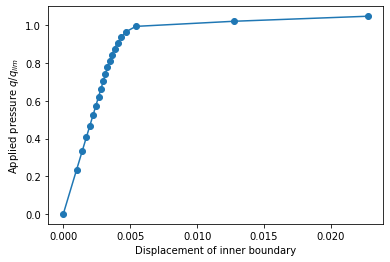

In [ ]:
if len(points_on_proc) > 0:
    import matplotlib.pyplot as plt
    plt.plot(results[:, 0], results[:, 1], "-o")
    plt.xlabel("Displacement of inner boundary")
    plt.ylabel(r"Applied pressure $q/q_{lim}$")
    plt.savefig(f"displacement_rank{MPI.COMM_WORLD.rank:d}.png")
    plt.show()